In [2]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
    
# tf.config.experimental.set_visible_devices([], 'GPU')
# tf.debugging.set_log_device_placement(True)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [4]:
%%capture
prefix = 'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/weather/jobs/transform_batch/20220925-014051_e32aa567fa482e970513332d1d24fd51'

train_X = pd.read_parquet(f'{prefix}/train_x.parquet')
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')

validate_X = pd.read_parquet(f'{prefix}/validate_x.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')

test_X = pd.read_parquet(f'{prefix}/test_x.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

score_X = pd.read_parquet(f'{prefix}/score_x.parquet')

condition_window = 24
prediction_window = 24


In [5]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 826464 entries, ('Albuquerque/1108/0', Timestamp('2015-02-16 09:00:00')) to ('Vancouver/806/12', Timestamp('2014-07-03 04:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  826464 non-null  float64
 1   humidity     826464 non-null  float64
 2   pressure     826464 non-null  float64
 3   wind_speed   826464 non-null  float64
dtypes: float64(4)
memory usage: 31.9+ MB


In [6]:
score_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 57576 entries, ('Albuquerque/2249/0', Timestamp('2017-07-15 13:00:00')) to ('Vancouver/2623/10', Timestamp('2017-07-07 20:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  57576 non-null  float64
 1   humidity     57576 non-null  float64
 2   pressure     57576 non-null  float64
 3   wind_speed   57576 non-null  float64
dtypes: float64(4)
memory usage: 2.1+ MB


In [7]:
train_X.head()

temperature  humidity  pressure  \
sample             time                                                   
Albuquerque/1108/0 2015-02-16 09:00:00   276.323000      47.0    1031.0   
                   2015-02-16 10:00:00   275.097667      45.0    1032.0   
                   2015-02-16 11:00:00   273.931333      48.0    1032.0   
                   2015-02-16 12:00:00   274.380000      46.0    1033.0   
                   2015-02-16 13:00:00   272.675333      51.0    1033.0   

                                        wind_speed  
sample             time                             
Albuquerque/1108/0 2015-02-16 09:00:00         3.0  
                   2015-02-16 10:00:00         3.0  
                   2015-02-16 11:00:00         2.0  
                   2015-02-16 12:00:00         2.0  
                   2015-02-16 13:00:00         1.0

In [8]:
train_X.index.get_level_values(0).str.split('/').str[0].unique()

Index(['Albuquerque', 'Atlanta', 'Boston', 'Charlotte', 'Chicago', 'Dallas',
       'Denver', 'Detroit', 'Eilat', 'Haifa', 'Houston', 'Indianapolis',
       'Jacksonville', 'Jerusalem', 'Kansas City', 'Las Vegas', 'Los Angeles',
       'Miami', 'Minneapolis', 'Montreal', 'Nahariyya', 'Nashville',
       'New York', 'Philadelphia', 'Phoenix', 'Pittsburgh', 'Portland',
       'Saint Louis', 'San Antonio', 'San Diego', 'San Francisco', 'Seattle',
       'Tel Aviv District', 'Toronto', 'Vancouver'],
      dtype='object', name='sample')

In [9]:
test_X.index.get_level_values(0).str.split('/').str[0].unique()

Index(['Albuquerque', 'Atlanta', 'Boston', 'Charlotte', 'Chicago', 'Dallas',
       'Denver', 'Detroit', 'Eilat', 'Houston', 'Indianapolis', 'Jacksonville',
       'Jerusalem', 'Kansas City', 'Las Vegas', 'Miami', 'Minneapolis',
       'Nashville', 'New York', 'Philadelphia', 'Phoenix', 'Pittsburgh',
       'Saint Louis', 'San Antonio', 'San Diego', 'San Francisco',
       'Tel Aviv District', 'Toronto', 'Vancouver'],
      dtype='object', name='sample')

In [10]:
# from sklearn.preprocessing import OneHotEncoder

# def get_additional_features(df):
#     # df.reset_index(inplace=True)
#     df['year'] = df.index.get_level_values(1).year
#     df['month'] = df.index.get_level_values(1).month
#     # df['day'] = df.index.get_level_values(1).day
#     df['location'] = df.index.get_level_values(0).str.split('/').str[0]
#     # df['location_id'], _ = pd.factorize(df['location'])
#     df['year_month'] = df['year'].astype(str) + "_" + df['month'].astype(str)
    
#     # location_dummies = pd.get_dummies(df['location'], prefix='location', dtype=float)
#     year_month_dummies = pd.get_dummies(df['year_month'], prefix='ym', dtype=float)
    
#     # df_new = pd.concat([df, location_dummies, year_month_dummies], axis=1)
#     df_new = pd.concat([df, year_month_dummies], axis=1)
    
#     df_new.drop(columns = ['year', 'month', 'location', 'year_month'], inplace=True)
    
#     return df_new

# train_X = get_additional_features(train_X)
# train_y = get_additional_features(train_y)
# validate_X = get_additional_features(validate_X)
# validate_y = get_additional_features(validate_y)
# test_X = get_additional_features(test_X)
# test_y = get_additional_features(test_y)
# score_X = get_additional_features(score_X)

In [11]:
cols_to_scale = ['temperature', 'humidity', 'pressure', 'wind_speed']

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_X[cols_to_scale])

scaled_X = {
    'train': np.hstack((scaler.transform(train_X[cols_to_scale]), 
                        train_X[[col for col in train_X.columns if col not in cols_to_scale]].to_numpy())),
    'validate': np.hstack((scaler.transform(validate_X[cols_to_scale]), 
                           validate_X[[col for col in validate_X.columns if col not in cols_to_scale]].to_numpy())),
    'test': np.hstack((scaler.transform(test_X[cols_to_scale]), 
                       test_X[[col for col in test_X.columns if col not in cols_to_scale]].to_numpy())),
    'score': np.hstack((scaler.transform(score_X[cols_to_scale]), 
                        score_X[[col for col in score_X.columns if col not in cols_to_scale]].to_numpy())),
}

In [13]:
# Keras RNN cells expect inputs with 3 dimensions:
# (batch_size, condition_window, features_length)
# Each RNN cell takes a vector of features_length
# at each time step of condition_window.
# Internal RNN cell state is reset between different batch samples.

# Let's review current shapes of the input, and the desired shapes.
features_length = len(train_y.columns)

def expected_X_shape(actual_X_shape):
    return (int(actual_X_shape[0]/condition_window), condition_window, features_length)

def expected_y_shape(actual_y_shape):
    return (int(actual_y_shape[0]/prediction_window), prediction_window)


pd.DataFrame({
    'actual shape': [
        train_X.shape, 
        train_y.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
    ],
}, index=['train_X', 'train_y'])

,actual shape,expected shape
train_X,"(826464, 4)","(34436, 24, 4)"
train_y,"(826464, 4)","(34436, 24)"


In [14]:
pd.DataFrame({
    'actual shape': [
        validate_X.shape, 
        validate_y.shape,
    ],
    'expected shape': [
        expected_X_shape(validate_X.shape), 
        expected_y_shape(validate_y.shape), 
    ],
}, index=['validate_X', 'validate_y'])

,actual shape,expected shape
validate_X,"(54912, 4)","(2288, 24, 4)"
validate_y,"(54912, 4)","(2288, 24)"


In [15]:
# Exepected shape can be achieved with a simple reshape call.
# Note that these are not Pandas data frames any more,
# but Numpy n-dimensional arrays.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html


def frame_to_ndarray(frame_X, frame_y):
    X_nd = frame_X.reshape(-1, condition_window, features_length) #.astype('float32')
    y_nd = frame_y['temperature'].values.reshape(-1, prediction_window) #.astype('float32')
    return X_nd, y_nd

train_X_nd, train_y_nd = frame_to_ndarray(scaled_X['train'], train_y)
validate_X_nd, validate_y_nd = frame_to_ndarray(scaled_X['validate'], validate_y)

# Task: Transform other segments of the dataset (test, and score).
test_X_nd, test_y_nd = frame_to_ndarray(scaled_X['test'], test_y)
score_X_nd = scaled_X['score'].reshape(-1, condition_window, features_length) #.astype('float32')

In [16]:
# Let's confirm the expected shape.

pd.DataFrame({
    'actual shape': [
        train_X_nd.shape, 
        train_y_nd.shape,
        validate_X_nd.shape,
        validate_y_nd.shape,
        test_X_nd.shape,
        test_y_nd.shape,
        score_X_nd.shape
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
        expected_X_shape(validate_X.shape), 
        expected_y_shape(validate_y.shape), 
        expected_X_shape(test_X.shape),
        expected_y_shape(test_y.shape),
        expected_X_shape(score_X.shape)
    ]},
    index=['train_X', 'train_y', 'validate_X', 'validate_y', 'test_X', 'test_y', 'score_X']
)

,actual shape,expected shape
train_X,"(34436, 24, 4)","(34436, 24, 4)"
train_y,"(34436, 24)","(34436, 24)"
validate_X,"(2288, 24, 4)","(2288, 24, 4)"
validate_y,"(2288, 24)","(2288, 24)"
test_X,"(2177, 24, 4)","(2177, 24, 4)"
test_y,"(2177, 24)","(2177, 24)"
score_X,"(2399, 24, 4)","(2399, 24, 4)"


In [17]:
from tensorflow.keras.layers import GRU, Dense, BatchNormalization, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotUniform

layers = [
        LSTM(
            input_shape=(condition_window, features_length),
            units=48,
            return_sequences=True,  # support another recurrent layer below
            recurrent_activation='sigmoid',
            # reset_after=True,
            kernel_initializer=GlorotUniform(seed=45),
            recurrent_initializer=GlorotUniform(seed=46),
        ),
        BatchNormalization(),
        LSTM(
            units=16,
            return_sequences=False,  # only use the last activation for prediction
            recurrent_activation='sigmoid',
            # reset_after=True,
            kernel_initializer=GlorotUniform(seed=49),
            recurrent_initializer=GlorotUniform(seed=50),
        ),
        BatchNormalization(),
        Dense(
            units=prediction_window,
            kernel_initializer=GlorotUniform(seed=1),
            activation='linear'
        )
]

model = Sequential(layers)

In [18]:
# from tensorflow.keras.layers import GRU, Dense, BatchNormalization, LSTM, Dropout
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.initializers import GlorotUniform

# layers = [
#         GRU(
#             input_shape=(condition_window, features_length),
#             units=48,
#             return_sequences=True,  # support another recurrent layer below
#             recurrent_activation='sigmoid',
#             reset_after=True,
#             kernel_initializer=GlorotUniform(seed=47),
#             recurrent_initializer=GlorotUniform(seed=48),
#         ),
#         BatchNormalization(),
#         GRU(
#             units=16,
#             return_sequences=False,  # only use the last activation for prediction
#             recurrent_activation='sigmoid',
#             reset_after=True,
#             kernel_initializer=GlorotUniform(seed=49),
#             recurrent_initializer=GlorotUniform(seed=50),
#         ),
#         BatchNormalization(),
#         Dense(
#             units=prediction_window,
#             kernel_initializer=GlorotUniform(seed=2),
#             activation='linear'
#         )
# ]

# model = Sequential(layers)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 48)            10176     
                                                                 
 batch_normalization (BatchN  (None, 24, 48)           192       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 16)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
Total params: 15,000
Trainable params: 14,872
Non-traina

In [20]:
from utils import r2_score, mean_error
from tensorflow.keras.optimizers import Adam

# IMPORTANT: In order to pass the assignment, you need
# to improve the architecture and/or training procedure of this model.
# You CAN NOT submit the model as is. Please add plain English Python
# comments on how you modified the model and/or training procedure.

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mean_squared_error',
    metrics=[
        'mean_absolute_error',
        mean_error,
        r2_score,
    ]
)

In [26]:
%%time

from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

# IMPORTANT: In order to pass the assignment, you need
# to improve the architecture and/or training procedure of this model.
# You CAN NOT submit the model as is. Please add plain English Python
# comments on how you modified the model and/or training procedure.

history = model.fit(
    train_X_nd,
    train_y_nd,
    validation_data=(validate_X_nd, validate_y_nd),
    epochs=10,
    batch_size=100,
    callbacks=[
        TerminateOnNaN(), # stops training if gradient becomes NaN
        ReduceLROnPlateau(
            monitor='loss',
            min_delta=0.1,
            patience=5,
            factor=0.1,
            cooldown=10,
            verbose=1
        ),
        EarlyStopping(
            monitor='loss',
            min_delta=0.1,
            patience=10
        )
    ]
)

Epoch 1/10
345/345 [==============================] - 9s 26ms/step - loss: 14.4397 - mean_absolute_error: 2.8231 - mean_error: 0.0122 - r2_score: 0.8925 - val_loss: 21.1788 - val_mean_absolute_error: 3.5265 - val_mean_error: -1.5518 - val_r2_score: 0.3678 - lr: 0.0100
Epoch 2/10
345/345 [==============================] - 9s 26ms/step - loss: 14.3107 - mean_absolute_error: 2.8188 - mean_error: 0.0052 - r2_score: 0.8932 - val_loss: 21.7346 - val_mean_absolute_error: 3.5816 - val_mean_error: 0.2440 - val_r2_score: 0.4131 - lr: 0.0100
Epoch 3/10
345/345 [==============================] - 9s 26ms/step - loss: 14.5861 - mean_absolute_error: 2.8566 - mean_error: -0.0184 - r2_score: 0.8914 - val_loss: 61.3757 - val_mean_absolute_error: 6.9012 - val_mean_error: -6.4810 - val_r2_score: -1.2622 - lr: 0.0100
Epoch 4/10
345/345 [==============================] - 9s 26ms/step - loss: 14.1274 - mean_absolute_error: 2.8011 - mean_error: -0.0091 - r2_score: 0.8953 - val_loss: 19.4579 - val_mean_absolut

In [27]:
# Note that Keras evaluates metrics in batches,
# which is okay for averaging-stable metrics like ME, MSE, and MAE,
# but R2 requires full dataset to evaluate precisely.

# This implies two things:
# 1) R2 as reported during training is not precise
# 2) when evaluating R2 after training, batch size must match dataset size

nd_array_by_segment = {
    'train': (train_X_nd, train_y_nd),
    'validate': (validate_X_nd, validate_y_nd),
    'test': (test_X_nd, test_y_nd)
}

metrics_by_segment = {
    segment: model.evaluate(
        X_nd, 
        y_nd, 
        verbose=0, 
        batch_size=X_nd.shape[0]
    )
    for segment, (X_nd, y_nd) in nd_array_by_segment.items()
}

rnn_metrics = pd.concat([
    pd.DataFrame(
        data=[metrics], 
        columns=['MSE', 'MAE', 'ME', 'R2'], 
        index=[segment]
    )
    for segment, metrics in metrics_by_segment.items()
])

rnn_metrics = pd.DataFrame([rnn_metrics.unstack()], index=['rnn'])\
    .swaplevel(axis=1, i=0, j=1)\
    .reindex(nd_array_by_segment.keys(), axis=1, level=0)\
    .round(2)

rnn_metrics

train                   validate                   test                 
       MSE   MAE    ME    R2      MSE   MAE   ME   R2    MSE   MAE   ME    R2
rnn  11.53  2.47 -0.28  0.92    17.49  3.09  0.1  0.8  12.58  2.66 -0.6  0.83

In [28]:
from utils import SegmentDataset, baseline_metrics

segment_names = ['train', 'validate', 'test']
panel_dataset = SegmentDataset.from_pq_workdir(prefix, segment_names, ['x', 'y'])
baseline_metrics = baseline_metrics(panel_dataset)

In [29]:
pd.concat([
    baseline_metrics,
    rnn_metrics
], axis=0).loc[:, [('train', 'MSE'), ('train', 'R2'), 
                   ('validate', 'MSE'), ('validate', 'R2'),
                   ('test', 'MSE'), ('test', 'R2')]].round(3)

train       validate         test      
              MSE    R2      MSE    R2    MSE    R2
mean        26.77  0.80    37.23  0.58  28.52  0.61
constant    21.82  0.84    40.25  0.54  20.20  0.72
regression  30.53  0.78    29.94  0.66  33.64  0.54
rnn         11.53  0.92    17.49  0.80  12.58  0.83

In [34]:
score_X_nd.shape

(2399, 24, 4)

In [35]:
score_X_nd[0]

array([[0.6384    , 0.46315789, 0.75085324, 0.06818182],
       [0.63893333, 0.53684211, 0.75085324, 0.06818182],
       [0.68626667, 0.46315789, 0.75426621, 0.04545455],
       [0.69973333, 0.41052632, 0.75426621, 0.06818182],
       [0.73333333, 0.32631579, 0.75085324, 0.06818182],
       [0.7532    , 0.24210526, 0.75085324, 0.02272727],
       [0.78666667, 0.21052632, 0.75085324, 0.04545455],
       [0.8       , 0.17894737, 0.74744027, 0.11363636],
       [0.81333333, 0.14736842, 0.7440273 , 0.04545455],
       [0.80533333, 0.14736842, 0.74061433, 0.06818182],
       [0.81866667, 0.13684211, 0.73720137, 0.04545455],
       [0.82666667, 0.12631579, 0.73037543, 0.13636364],
       [0.8       , 0.15789474, 0.7337884 , 0.13636364],
       [0.7596    , 0.26315789, 0.7337884 , 0.22727273],
       [0.74133333, 0.53684211, 0.7440273 , 0.18181818],
       [0.6796    , 0.53684211, 0.7440273 , 0.09090909],
       [0.67186667, 0.53684211, 0.7440273 , 0.11363636],
       [0.6656    , 0.57894737,

In [31]:
score_y_hat = model.predict(score_X_nd)

In [33]:
score_y_hat.shape

(2399, 24)

In [38]:
score_y_hat_reshaped = score_y_hat.reshape(score_y_hat.shape[0]*score_y_hat.shape[1], 1)

In [40]:
score_y_hat_reshaped.shape

(57576, 1)

In [41]:
# TODO: save your predictions on the Score segment as a Pandas data frame
# into a variable named score_y_hat.
score_y_hat_df = pd.DataFrame(score_y_hat_reshaped, columns=['temperature'])

# Keras model will output an array of shape (2399, 24) for the Score segment,
# however the expected shape of the submitted data frame is (57576, 1).
# 57576 = 2399 (count of samples in Score segment) x 24 (prediction window).
# Use NumPy's reshape() or ravel() functions to achieve this.

# Finally, the data frame needs to have string column names in order to be saved
# as a Parquet file. If you convert a NumPy array to Pandas data frame,
# column names will be integers, but you can replace the columns names.
# There was a similar example of this in the notebook from the first assignment.

# Expected output: (Index(['temperature'], dtype='object'), (57576, 1))
score_y_hat_df.columns, score_y_hat_df.shape

(Index(['temperature'], dtype='object'), (57576, 1))

In [42]:
# Once you are satisfied with your model,
# your need to submit 4 files:
# 1. this notebook and/or any other Python scripts
# 2. Model definition in JSON format
# 3. Model parameters in H5 format
# 4. temperature forecast for the Score segment

import os
model_dir = 'weathernet_model'
os.makedirs(model_dir, exist_ok=True)

# Save model definition:
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"{model_dir}/keras_parameters.h5")

# Finally, let's save the forecast.
score_y_hat_df.to_parquet(f'{model_dir}/score_y_hat.parquet')

# RNN model experiments

While my experiments were not at scale, I made attempts on changing cell types, model architectures, and adding auxilliary variables to see if there was improvements on the R squared of the test data. 

## Cell type
I found that LSTM cells perform better than GRU given other hyperparameters remain the same. 

## Model architecture
I stacked more layers to the GRU or LSTM as well as added more Dense layers. Neither performed better than a simpler architecture with 2 LSTM layers and 1 Dense decoder layer. In fact, more GRU layers resulted in a negative R squared. I also tried adding Dropout layers with a rate of 0.05 in between the LSTM / GRU layers to prevent overfitting on the training dataset but that did not improve performance. 

## Feature scaler
Assignment template suggested the scaling of the features to have a distribution of mean 0 and variance 1. After looking at the features, their distributions do not look close to normal. For example, wind speed and pressure are clustered around certain values rather than symmetrically spread out. By using MinMaxScaler, I did not assume the feature distribution but made the feature range from 0 to 1. This change increased the R squared to 0.83.

## Auxillary variables
Intuitively adding more features for the model to learn should increase model fit (i.e., R squared). However, the feature engineering was not as straightforward as I thought. Locations and calendar features are categorical variables. For example, after adding four more columns, such as year, month, day, and location ID (which was assigned to each unique city), I didn't apply the scaler to these variables because they were nominal with no order. The addition of these categorical variables decreased model fit, indicating an alternative needed to include these categorical variables.

Perhaps I needed to explore better features, such as the lattitude and longitude of cities, the continent in which these cities are in, or more aggregated temperature at the city level (e.g., city average monthly temperature, city maximum weekly temperature, etc.). Perhaps I needed to add regularization layers to my architecture. For this assignment, I've decided to cap my efforts at a 0.83 score for the test set. 

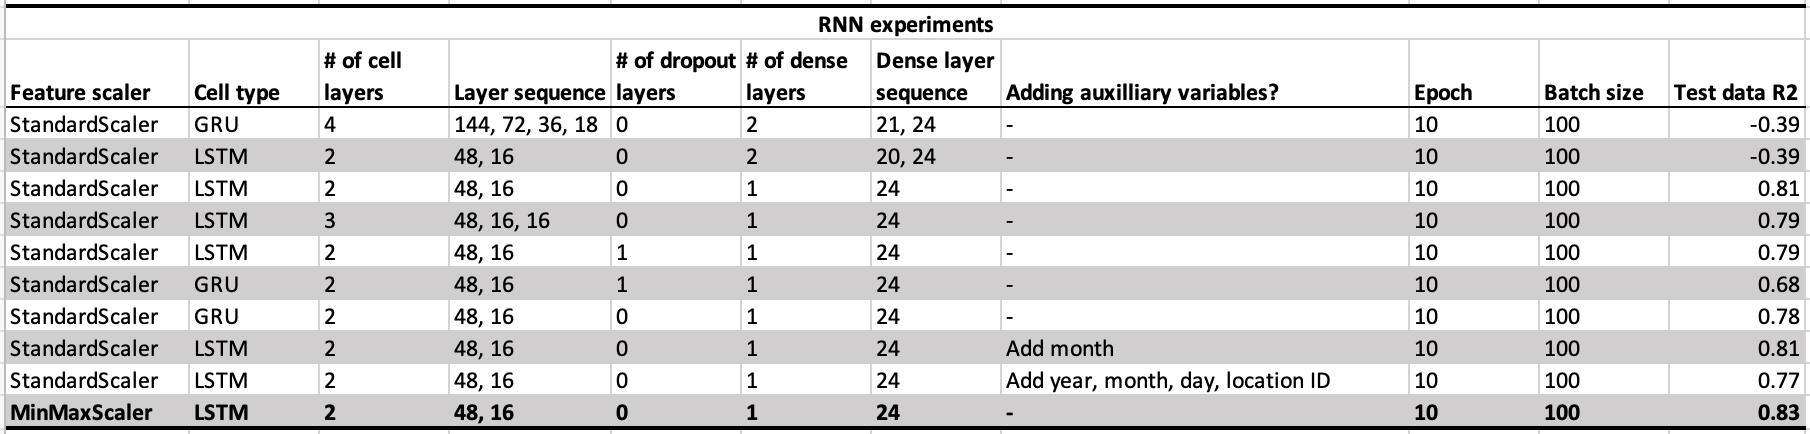

In [44]:
from IPython.display import Image

image_path = 'RNN Experiments.png'
Image(filename=image_path)